In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
import warnings
import math
import yfinance as yf

%matplotlib inline

warnings.filterwarnings('ignore')

In [220]:
data_GOOG_mounth = yf.download('GOOG','1990-01-01','2019-08-01').groupby(pd.Grouper(freq='m')).mean()
data_IBM_mounth = yf.download('IBM','1990-01-01','2019-08-01').groupby(pd.Grouper(freq='m')).mean()
data_AAPL_mounth = yf.download('AAPL','1997-01-01','2019-08-01').groupby(pd.Grouper(freq='m')).mean()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [212]:
def correlation(x: np.ndarray, y: np.ndarray):
    assert y.shape[0] == x.shape[0], "Wrong len"
    count = x.shape[0]
    x_mean = x.mean()
    y_mean = y.mean()
    std_deviation_x = math.sqrt(sum((x - x_mean) ** 2) / count)
    std_deviation_y = math.sqrt(sum((y - y_mean) ** 2) / count)
    correlation = ((x - x_mean) * (y - y_mean)).mean() / (std_deviation_x * std_deviation_y)
    return correlation

def autocorrelation_function(x: np.ndarray, max_lag=12):
    correlations = []
    count = x.shape[0] if  x.shape[0] > 24 else x.shape[0] - 1
    
    for lag in range(max_lag + 1):
        correlations.append(correlation(x[lag:], x[:count - lag]))
        
    assert abs(correlations[0] - 1) < 1e-6
    plt.scatter(list(range(max_lag + 1)), correlations)

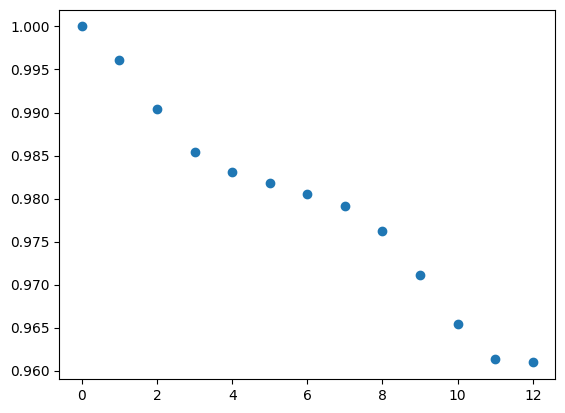

In [213]:
autocorrelation_function(data_GOOG_mounth['Adj Close'].to_numpy())

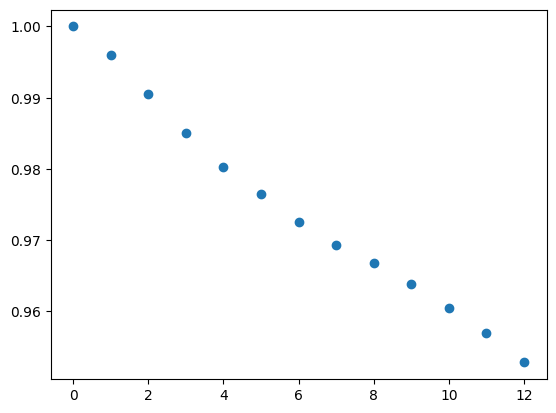

In [214]:
autocorrelation_function(data_IBM_mounth['Adj Close'].to_numpy())

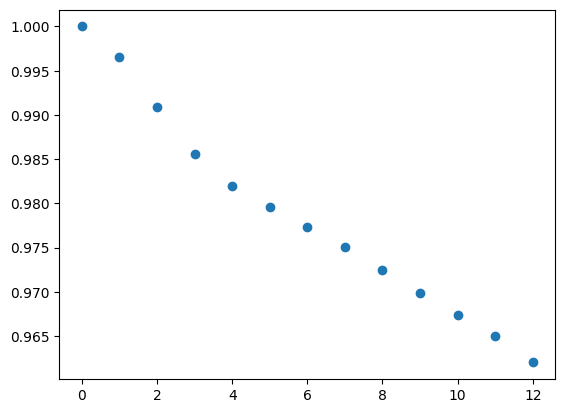

In [215]:
autocorrelation_function(data_AAPL_mounth['Adj Close'].to_numpy())

In [219]:
class AutoRegression:
    def __init__(self, data: pd.DataFrame, column_of_interest: str, rank=1):
        self.regression = LinearRegression()
        self.column = column_of_interest
        self.rank = rank
        
        self.prepare_data(data)
        self.init_regression()
        
    def prepare_data(self, data: pd.DataFrame):
        count = len(data.index)
        data = data[self.column]
        self.x = self.get_x(data)
        self.y = data[self.rank:].to_numpy().reshape(-1, 1)
        assert self.y.shape[0] == self.x.shape[0], "Wrong len"
    
    def get_x(self, data):
        count = len(data.index)
        reversed_offsets = list(range(self.rank, -1, -1))
        for offset in range(self.rank):
            if offset + 1 == 1:
                x = data[reversed_offsets[offset] : count - offset].to_numpy().reshape(-1, 1)
            else:
                x = np.concatenate([x, data[reversed_offsets[offset] : count - offset].to_numpy().reshape(-1, 1)], axis=1)
        return x
    
    def init_regression(self):
        self.regression.fit(self.x, self.y)
        self.preds = self.regression.predict(self.x)
        self.cals_errors()
        
    def predict_with_plot(self, data: np.ndarray):
        x = self.get_x(data)
        preds = self.regression.predict(x)
        x_for_plot = list(range(x.shape[0]))
        plt.plot(x_for_plot, preds)
        plt.plot(x_for_plot, data[:-1])
        
    def cals_errors(self):
        self.err = self.y - self.preds
        
    def get_r_square(self):
        squared_errors = (self.err**2).sum()
        mean_y = self.y.mean()
        squared_deviations = sum([(observation - mean_y)**2 for observation in self.y.flatten().tolist()])
        r_square = 1 - squared_errors/squared_deviations
        return r_square
    
    def get_errors_expectation(self):
        return self.err.mean()
    
    def draw_plots(self):
        fig, axes = plt.subplots(1, 2, figsize=(22, 7))
        count = self.y.shape[0]
        
        axes[0].plot(list(range(count)), self.y, label='Real y')
        axes[0].plot(list(range(count)), self.preds, label='Predicted y')
        axes[0].legend(loc='upper right')
        
        axes[1].scatter(list(range(count)), self.err, label='Error')
        axes[1].plot(list(range(count)), [0] * count, color='orange')
        axes[1].legend(loc='upper right')
        
        axes[0].set_title("Real data and model's predictions")
        axes[1].set_title("Errors of model")

In [203]:
data_GOOG = pd.read_excel("Data/Data_GOOG_No_Trend.xlsx")
data_IBM = pd.read_excel("Data/Data_IBM_No_Trend.xlsx")
data_AAPL = pd.read_excel("Data/Data_AAPL_No_Trend.xlsx")

# Auto regression models:

R_square: 1.0 
Expectation of errors: 1.429463789348246e-20


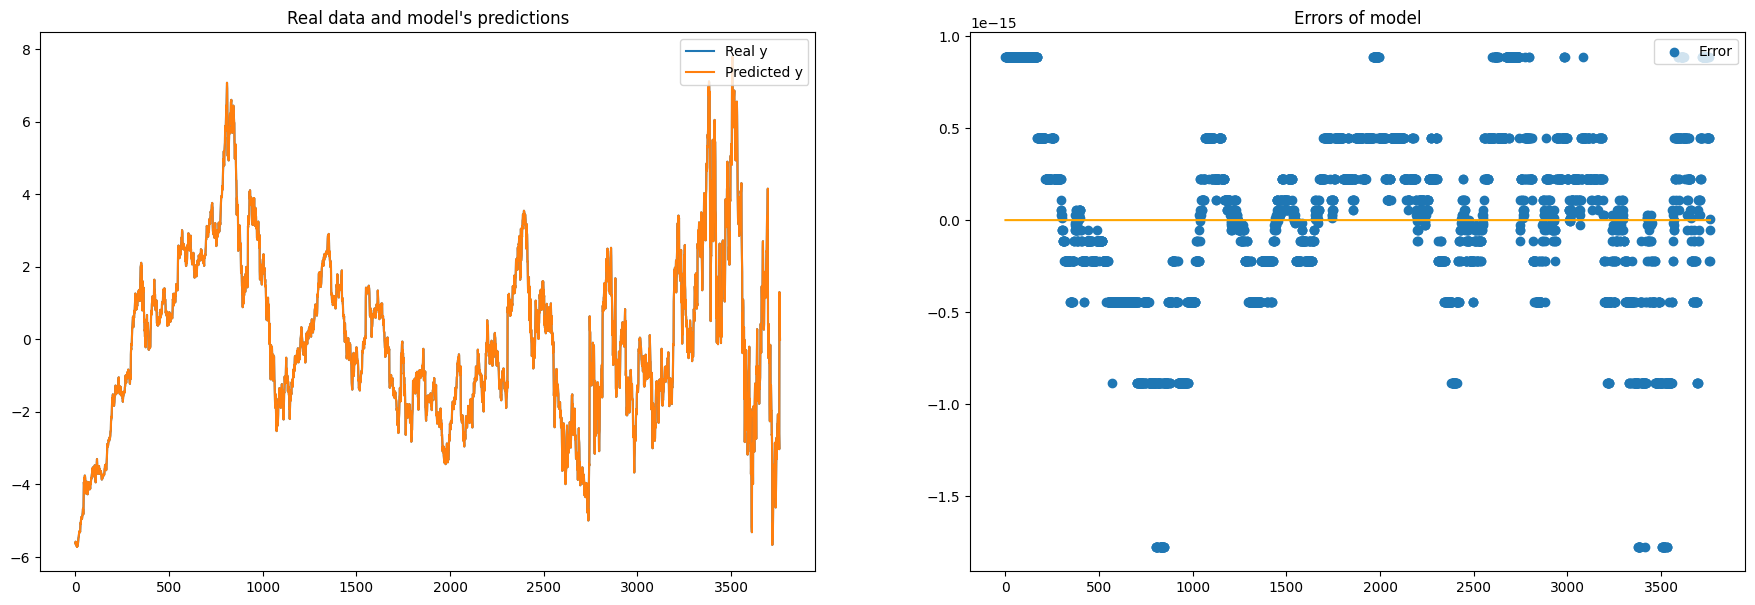

In [221]:
autoregression_GOOG = AutoRegression(data_GOOG, 'Adj Close', rank=1)
autoregression_GOOG.draw_plots()
print("R_square:", autoregression_GOOG.get_r_square(), "\nExpectation of errors:", autoregression_GOOG.get_errors_expectation())

R_square: 1.0 
Expectation of errors: 3.805066593860426e-18


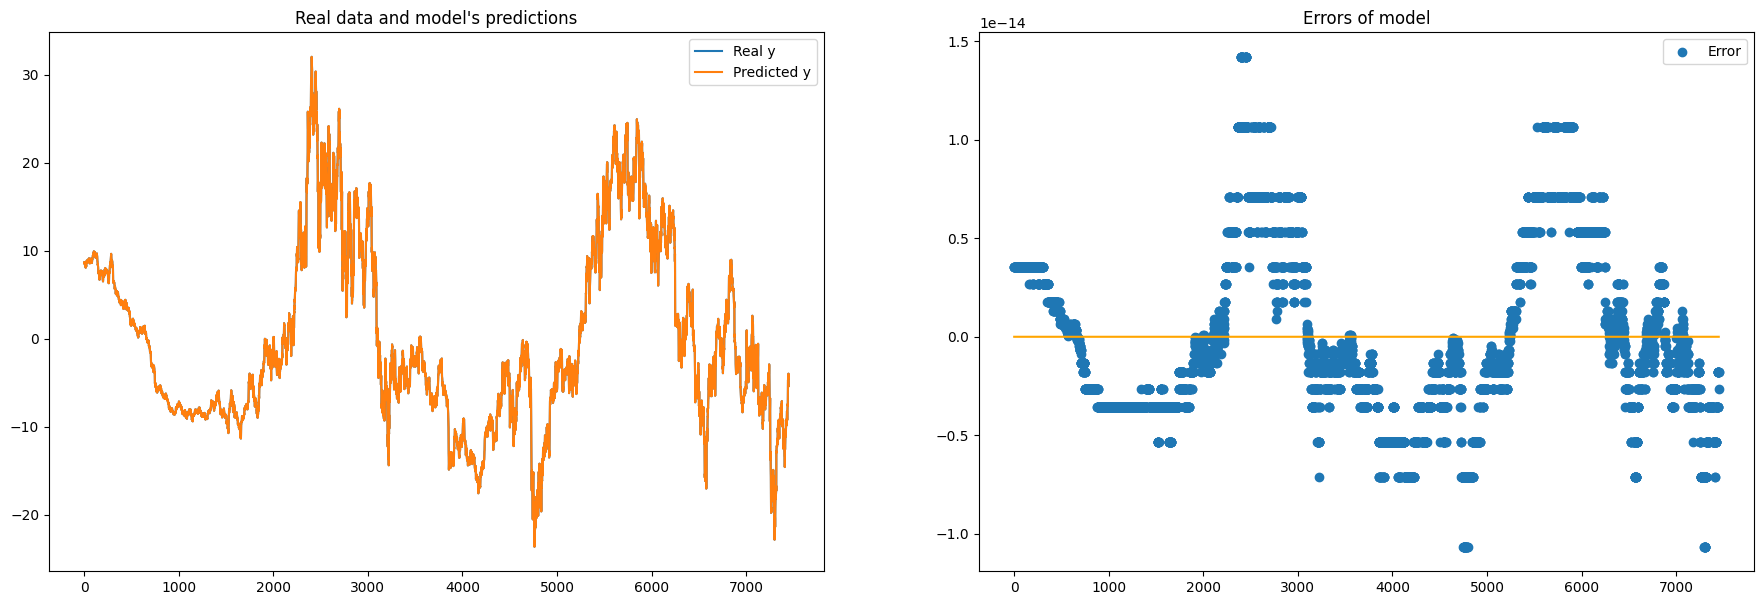

In [222]:
autoregression_IBM = AutoRegression(data_IBM, 'Adj Close', rank=1)
autoregression_IBM.draw_plots()
print("R_square:", autoregression_IBM.get_r_square(), "\nExpectation of errors:", autoregression_IBM.get_errors_expectation())

R_square: 1.0 
Expectation of errors: 6.041864989767994e-18


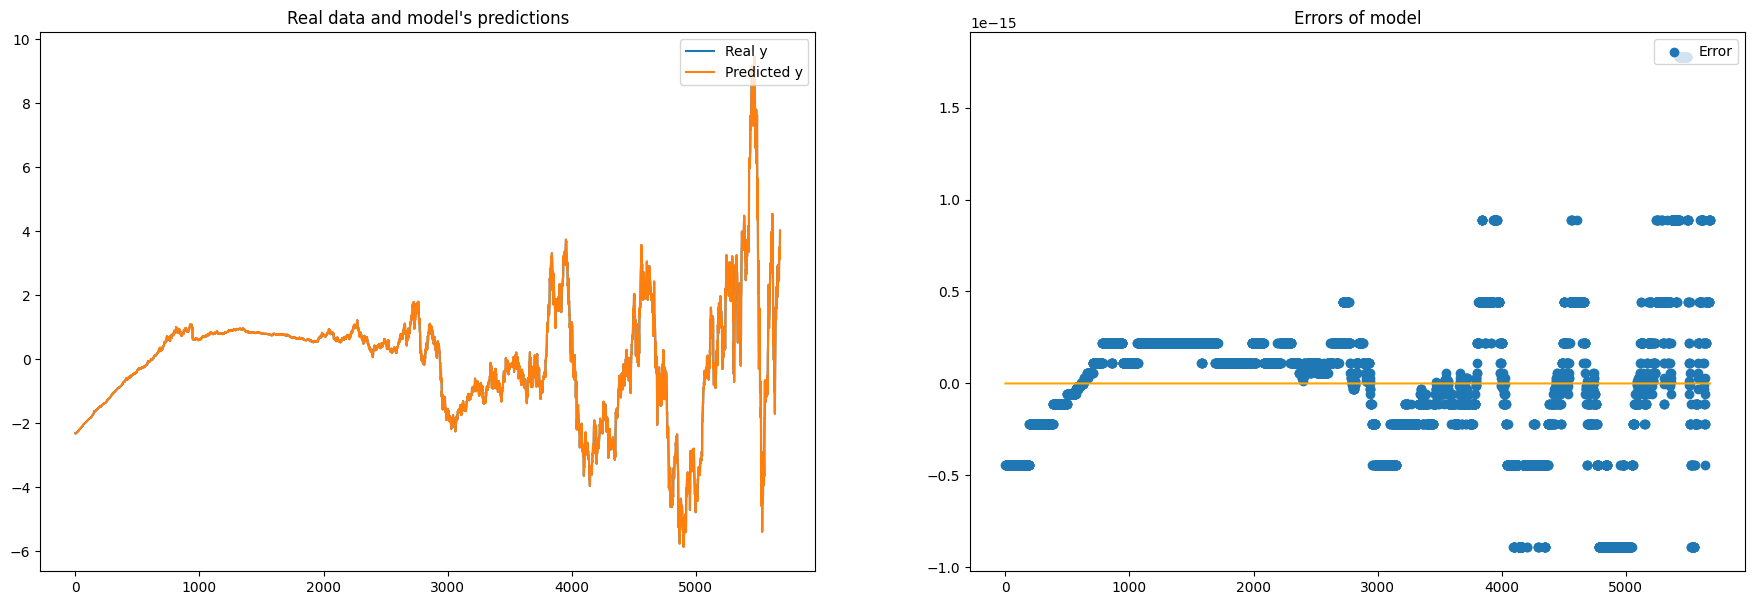

In [223]:
autoregression_AAPL = AutoRegression(data_AAPL, 'Adj Close', rank=1)
autoregression_AAPL.draw_plots()
print("R_square:", autoregression_AAPL.get_r_square(), "\nExpectation of errors:", autoregression_AAPL.get_errors_expectation())

# Auto regression moving average models: